# Covid Survival in Mexico Analysis

**What was done:**


1.   *Business Understanding*: 
  - understand the goal of this work and why it is important. (Section I)
2.   *Data Understanding*: 
  - Explore the dataset and column by column
  - Make sure that the data contained is correctly interpreted (eg. translating column names, finding the correct description of the columns on the official website on github, searching for papers to have a wider view of the work) (Section II)
3. *Data Preparation*: (Section III)
 - clean
 - filter
 - prepare data for further steps. 

  In this part of the looked more closely to errors, inconsistencies, and various type of problems that data in columns could have had and that could prevent our model from learning accurately. <br>
  In particular:
  - remove the un-necessary columns (the id created when inserting a new observation into the register and the date in which the new observation was inserted).
  - remove null values
  - convert categorical data to numerical
  - remove outliers (for example age 120 in the column 'EDAD')
  - normalize (min-max normalization) every column so that the model could not be biased from a different choice of range in the data
  - remove redundant column (using the pearson correlation between one another)
  - feature selection using PCA to reduce the number of columns and avoid falling into the *curse of dimensionality* problem. 


**What still needs to be done**:

3. *Data Preparation* (Section III): 
  -  This dataset is also unbalanced so we will study the best techniques to balance it and apply them to the dataset.


4. *Modelling* (Section IV)
  - Our goal for this section will be to train different models using cross-validation. Also, we want to see if the model performs better with or without feature selection. If we realise that the performance are lower after PCA, we shall search for other types of feature selection or try without. <br>
  - Another goal that we will like to achieve is to perform hyperparameter tuning on the best models and find out if the models could be tuned to obtain better results. <br>
  - We balanced our dataset in the previous section but other experiments could be executed on the model directly instead of the dataset: for example by applying weigths to each class. We will analyze this possibility.


5. *Evaluation* (Section V)
In this part we shall evaluate each model. Different metrics will be considered.


6. *Conclusion* (Section VI)
This part will conclude our work by discussing the techniques used and the various approaches studied.

# 1. Business Understanding

### **1.1 - Background**

After three years of pandemic, all the world knows about COVID19, a virus that causes severe acute respiratory syndrome (SARS-CoV-2). Over 106 million SARS-CoV-2 infections and over 2.3 million fatalities have been reported as of the first week of February 2021. This epidemic has severely disrupted global economic activity. 
In response to the worldwide public health crisis, scientists and physicians have worked very hard to give new insights and develop technology solutions that may assist in combating this infectious sickness and lessening its effects. <br>
<br>
Artificial intelligence approaches have been recognized in this context as a potent and promising technology that may help with:
<ul>
    <li>the diagnostic process</li>
    <li>prediction of disease spreading dynamics</li>
    <li>tracking of infected patients</li>
    <li> tracking of potential future patients</li>
    <li> determine if a particular patient poses a mortality risk</li>
</ul>

### **1.2 - Business Objectives**
In this scenario is important to improve hospital capacity planning and ensure that the right patient receive timely treatment.

### **1.3 - Business Success Criteria**
The business success criterias are met if health care priorities are currenty assigned and identify high-risk patients are quickly identified.

### **1.4 - Situation**
To our disposal we have a dataset containing 4 million entries of 40 attributes, each one containing information about a patient 


### **1.5 - Data Mining Goals**
Correctly identify patients who are more likely to die and patients who are more likely to survive.

### **1.6 - Data Mining Success Criteria**
The success criteria are satisfied if the model is able to identify patient with high precision in a fast way.

# 2. Data Understanding

### **2.1 - Initial Data Collection**

In [1]:
%%capture 
%pip install shap
%pip install category_encoders
%pip install imblearn
%pip install -U scikit-learn --user

In [2]:
# libraries import
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from pandas.api.types import is_numeric_dtype
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model
from scipy import stats
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import shap
import category_encoders as ce
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import compute_class_weight

from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict
from sklearn.metrics import (accuracy_score, 
                             precision_score,
                             recall_score, 
                             f1_score)

from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import BorderlineSMOTE
from collections import Counter

from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neural_network import MLPClassifier
from statistics import mean


sns.set_style("darkgrid")
sns.set_palette("Set2")

In [3]:
path  = "./dataset"

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# path = "/content/drive/MyDrive"
#df = pd.read_csv(path + "/COVID19MEXICO2020.csv")

In [5]:
df = pd.read_csv(path + "/COVID19MEXICO2020.csv")

In [6]:
print(f"Data has {df.shape[0]} rows and {df.shape[1]} attributes")

Data has 3779640 rows and 40 attributes


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3779640 entries, 1 to 3779640
Data columns (total 40 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   FECHA_ACTUALIZACION    object
 1   ID_REGISTRO            object
 2   ORIGEN                 int64 
 3   SECTOR                 int64 
 4   ENTIDAD_UM             int64 
 5   SEXO                   int64 
 6   ENTIDAD_NAC            int64 
 7   ENTIDAD_RES            int64 
 8   MUNICIPIO_RES          int64 
 9   TIPO_PACIENTE          int64 
 10  FECHA_INGRESO          object
 11  FECHA_SINTOMAS         object
 12  FECHA_DEF              object
 13  INTUBADO               int64 
 14  NEUMONIA               int64 
 15  EDAD                   int64 
 16  NACIONALIDAD           int64 
 17  EMBARAZO               int64 
 18  HABLA_LENGUA_INDIG     int64 
 19  INDIGENA               int64 
 20  DIABETES               int64 
 21  EPOC                   int64 
 22  ASMA                   int64 
 23  INMUSUP

### **2.2 - Data Description** 
The dataset is composed of 39 features and 1 target variable (TIPO_PACIENTE).

The target variable is a categorical variable that can be _1_ if the patient is more likely to survive or _2_ if the patient is more likely to die. 

We can see that the dataset is unbalanced (there are more paients who are more likely to survive than to die). This may cause our model to be biased and always predict the majority class with still retaining an higher level of accuracy. There are multiple solutions to this problem: one can be oversampling the minority class to balance the result but it may introduce dublicates and bias. Another solution can be to assign weigth to the classes and force the model to pay attention also to the minority. 

In [8]:
df[["TIPO_PACIENTE"]].value_counts()

TIPO_PACIENTE
1                3272882
2                 506758
dtype: int64

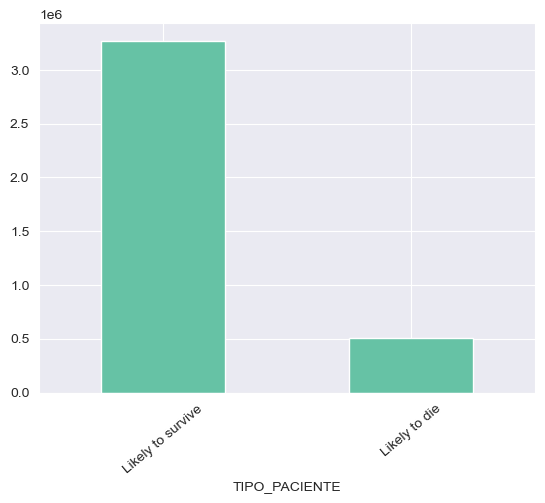

In [9]:
ax = df[["TIPO_PACIENTE"]].value_counts().plot(kind="bar")
ax.set_xticklabels(['Likely to survive', 'Likely to die'], rotation=40)
plt.show()

In [10]:
# categorical values have numerical identifier 
name_dict = {'SI': 1, 'NO': 2, 'DO NOT KNOW': 97, 'ANSWER REFUSED': 98, 'NOT APPLICABLE': 99}
#name_dict = {1: 'SI', 2: 'NO', 97: 'DO NOT KNOW', 98: 'ANSWER REFUSED', 99: 'NOT APPLICABLE'}

This dataset has 39 features, making it challenging to analyze it immediately. To make it easier, the features have been separated into three categories:

- 1. Medical History:

In [11]:
medical_history = ['DIABETES',  #Diabetes = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'OBESIDAD', #Obesity = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'ASMA', #Asthma = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'HIPERTENSION', #Hypertension = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'RENAL_CRONICA', #Chronic renal failure = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'CARDIOVASCULAR', #Cardiovascular diseases = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'EMBARAZO', #Pregnancy = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'TABAQUISMO', #Smoking = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'EPOC', #COPD = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'INMUSUPR', #Immunosuppressive drugs = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
    'OTRA_COM' #Other chronic illnesses = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
]

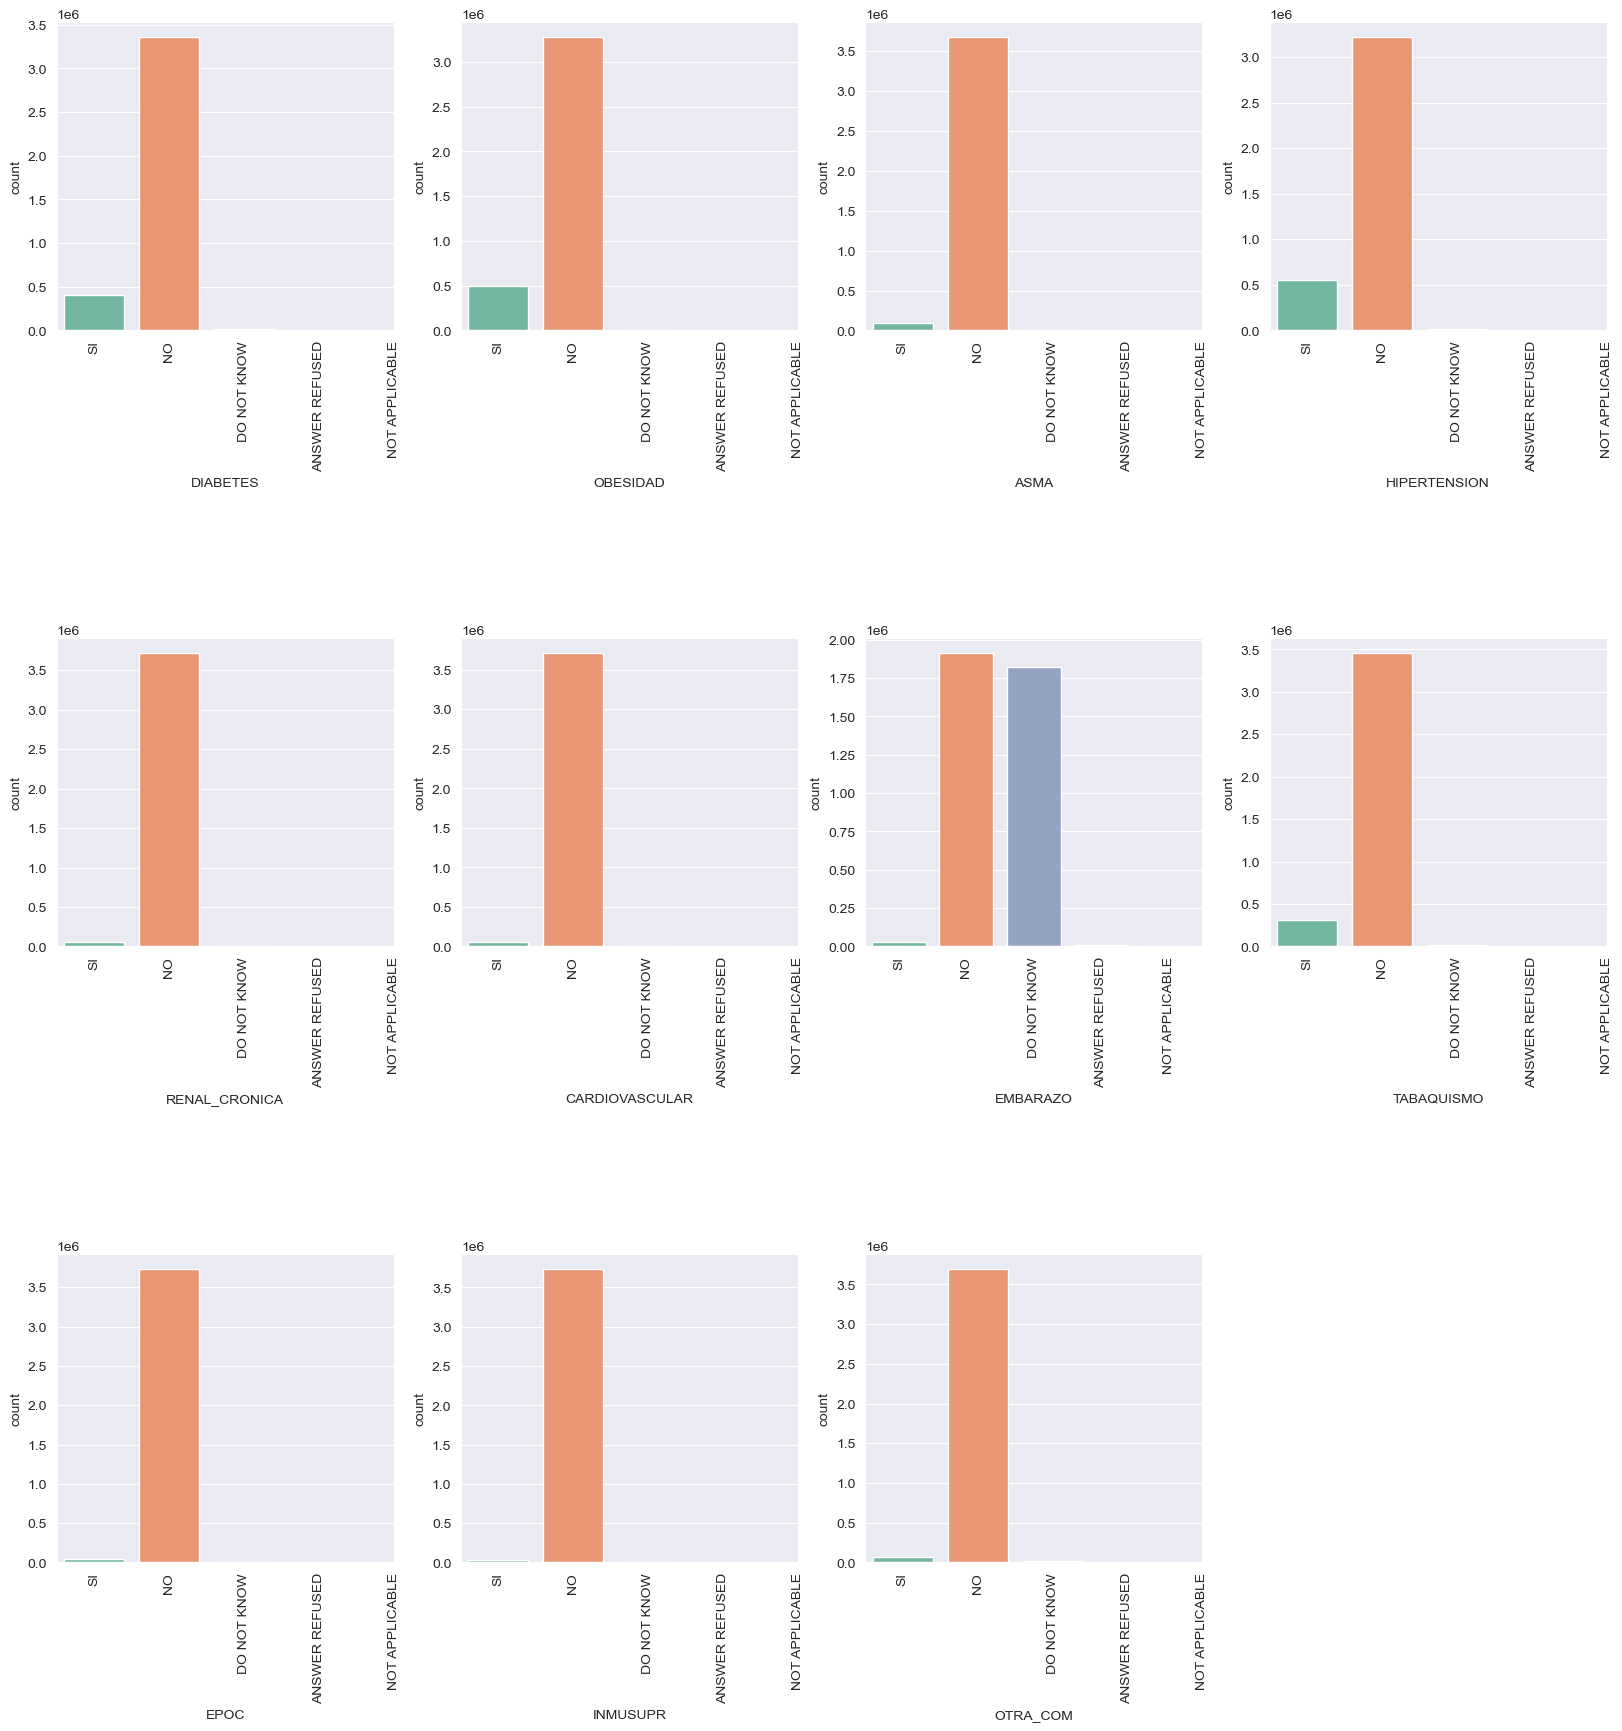

In [12]:
fig, ax = plt.subplots(3, 4, figsize=(20, 20))
fig.subplots_adjust(hspace=1)
for variable, subplot in zip(medical_history, ax.flatten()):
    chart = sns.countplot(x=df[variable], ax=subplot)
    chart.set_xticks(range(len(name_dict)), list(name_dict.keys()))
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
fig.delaxes(ax[2,3])

- We can detect an high number of NaNs in 'EMBARAZO' (this feature won't be of much help in our research due to this high number of nans).<br>
- We can observe that the majority of the patients wasn't in poor health (2=NO). <br>

<hr>

- 2. Demographic Data

In [13]:
demographic_data = ['SEXO', #gender (M/F)=(1/2)
                    'NACIONALIDAD', #nationality (1=mexican , 2=foreigner)
                    'INDIGENA', #indigeneous = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                    'HABLA_LENGUA_INDIG', #Indigeneous language = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                    'MIGRANTE', #migrant = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                    'PAIS_ORIGEN', #state of birth = categorical (text)
                    'PAIS_NACIONALIDAD', #state of residence  = categorical (text)
                    'ENTIDAD_NAC', #entity where patient was born = categorical (text)
                    'ENTIDAD_RES', #entity where patient is resident = categorical (text)
                    'EDAD', #age = numerical
                    'MUNICIPIO_RES', #municial where patient is resident = categorical (text)
                   ]

[Text(0, 0, 'MEXICAN'), Text(1, 0, 'FOREIGNER')]

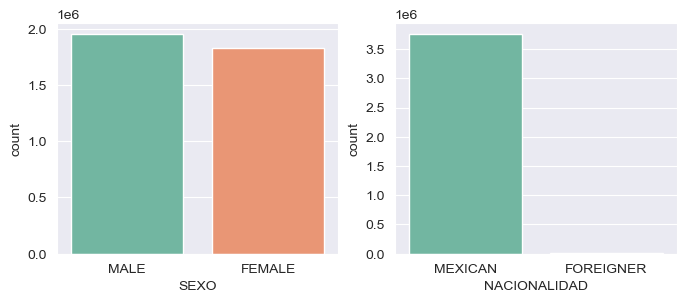

In [14]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8, 3))
sns.countplot(x=df[demographic_data[0]], ax=ax1).set_xticklabels(['MALE', 'FEMALE'])
sns.countplot(x=df[demographic_data[1]], ax=ax2).set_xticklabels(['MEXICAN', 'FOREIGNER'])

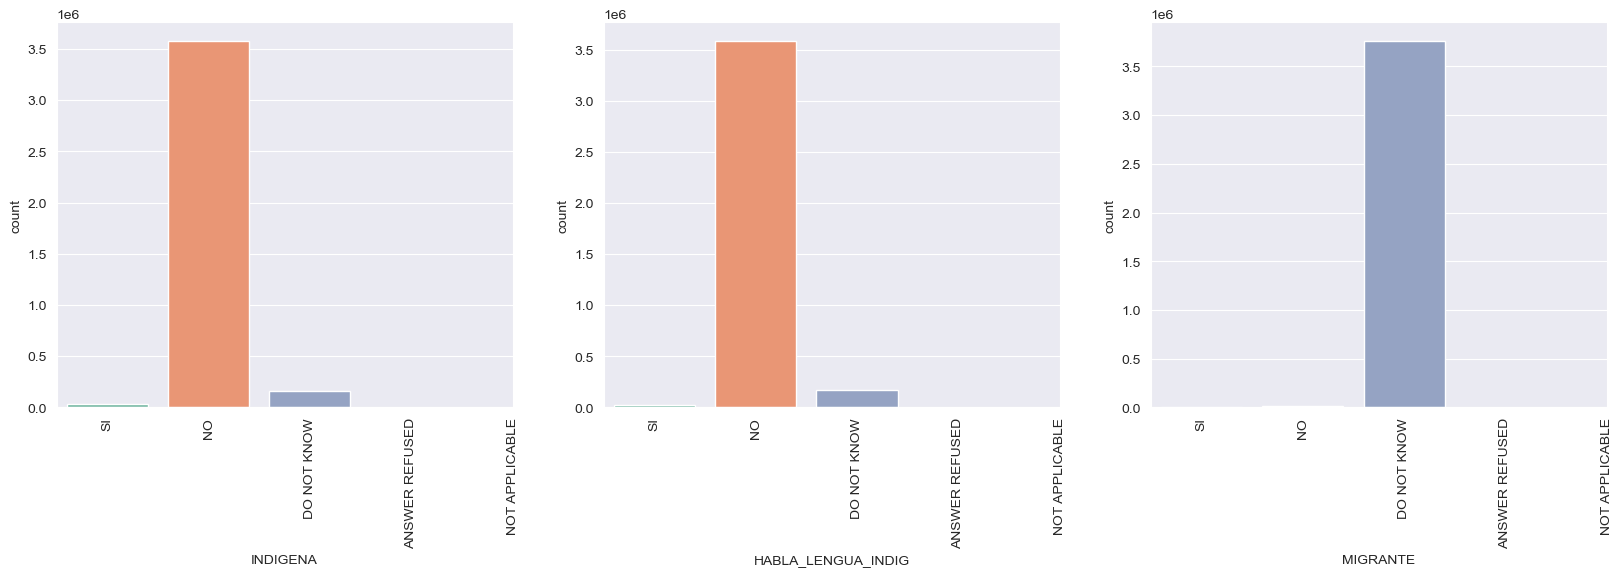

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for variable, subplot in zip(demographic_data[2:5], ax.flatten()):
    chart = sns.countplot(x=df[variable], ax=subplot)
    chart.set_xticks(range(len(name_dict)), list(name_dict.keys()))
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

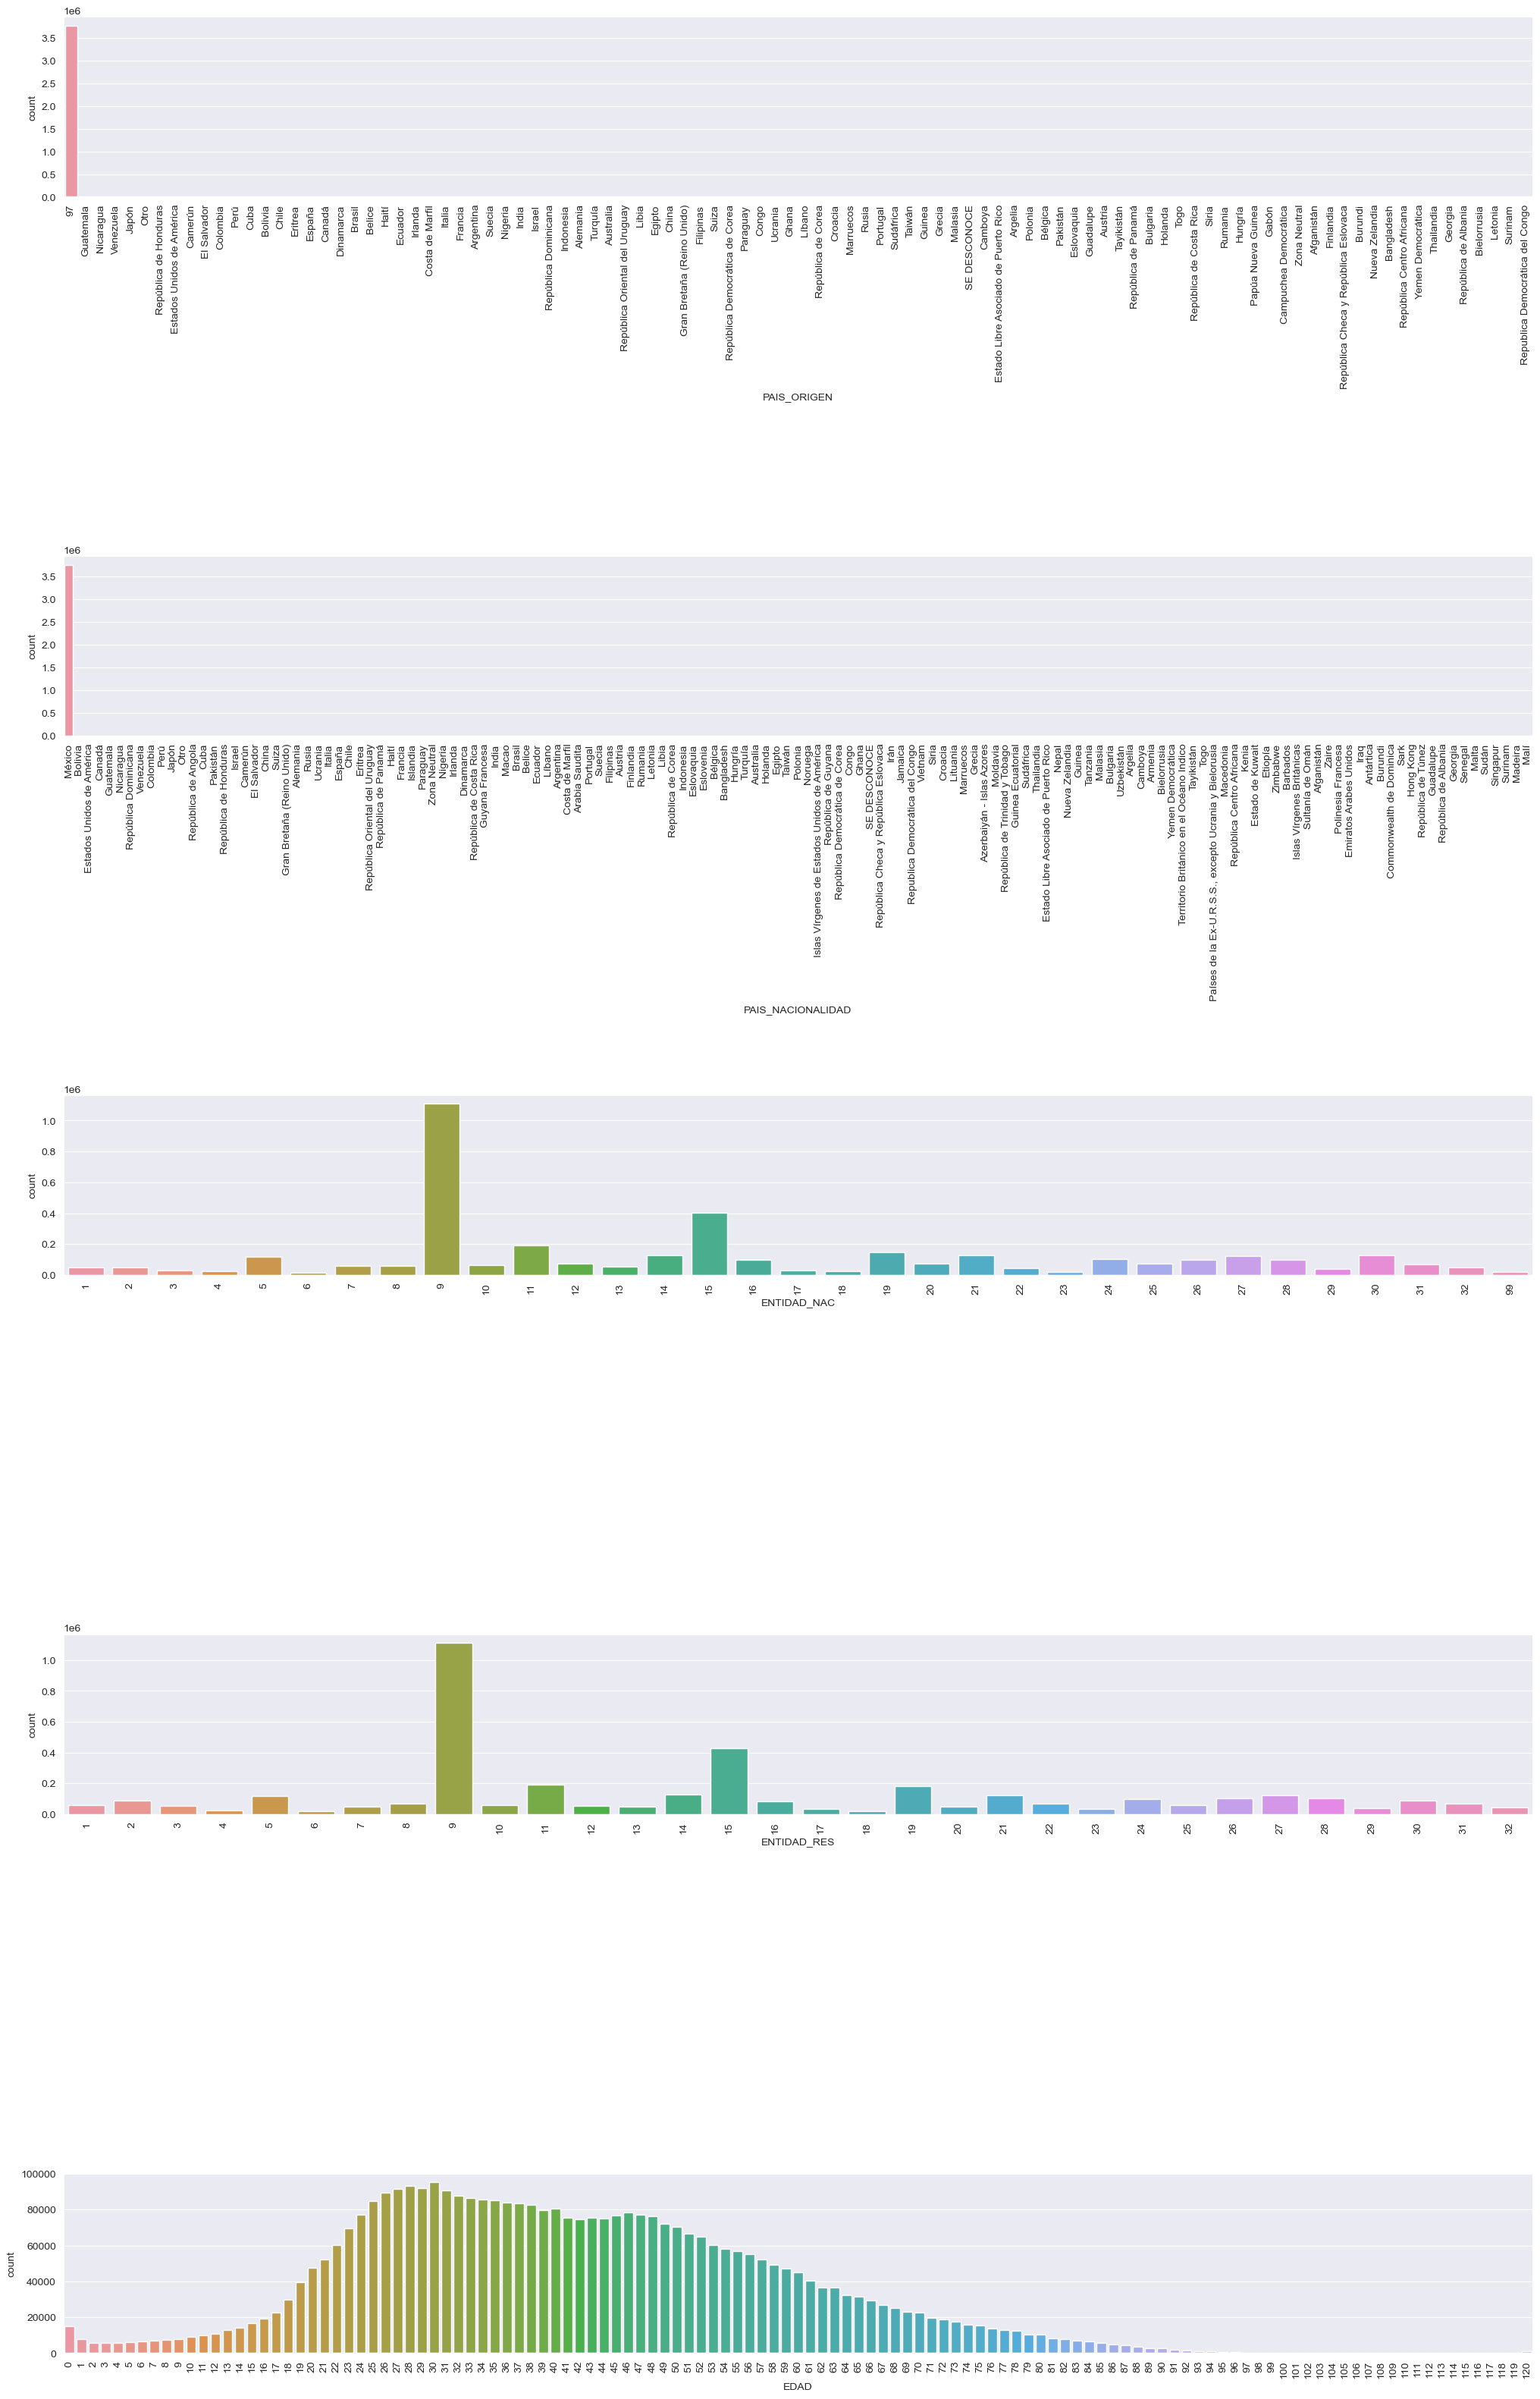

In [16]:
fig, ax = plt.subplots(5, 1, figsize=(25, 40))
fig.subplots_adjust(hspace=2)
for variable, subplot in zip(demographic_data[5:10], ax.flatten()):
    chart = sns.countplot(x=df[variable], ax=subplot)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

In [17]:
df[['MUNICIPIO_RES']].value_counts().sort_index()

MUNICIPIO_RES
1                100438
2                140073
3                120881
4                140736
5                200309
                  ...  
567                   3
568                   6
569                   1
570                 283
999                  37
Length: 520, dtype: int64

- in 'MIGRANTE' (migran) we can see many NaN's (97,98,99)
- from the other features we can derive that most of the people is mexican
- we can notice some outliers in the feature 'EDAD' (age): it's not likely that someone had 120 years
- male and female are balanced

<hr>

- 3. Recent Medical Info

In [18]:
medical_info = ['ID_REGISTRO', #id register = categorical (text)
                
                'ORIGEN', #system of respiratory disease monitoring health units (USMER) = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                'INTUBADO', #if the patient required intubation = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                'NEUMONIA', #PNEUMONIA = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                'OTRO_CASO', #if it has had contact with other covid cases = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                'TOMA_MUESTRA_LAB', #sample lab taken = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                'RESULTADO_LAB', #test covid19 result = categorical (COVID/HEALTHY/DONT KNOW/ANSWER REFUSED/NA)
                'TOMA_MUESTRA_ANTIGENO', #test antigeno taken = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                'RESULTADO_ANTIGENO', #test covid19 antigeno result = categorical (COVID/HEALTHY/DONT KNOW/ANSWER REFUSED/NA)
                'UCI',#if the patients was in the intense unit = categorical (SI/NO/DONT KNOW/ANSWER REFUSED/NA)
                
                'CLASIFICACION_FINAL', #Identifies if the patient is a case of COVID-19 = categorical (1-7)
                'ENTIDAD_UM', #entity of the medical unit = categorical
                'TIPO_PACIENTE', #type of attention that the patient has received on arrival = categorical (Ambulatorio/hospitalizado)
                
                'FECHA_SINTOMAS', #date of start symbols (YYYY-MM-DD)
                'FECHA_INGRESO', #date of arrival into medical unit (YYYY-MM-DD)
                'FECHA_DEF', #date of death (YYYY-MM-DD)
]

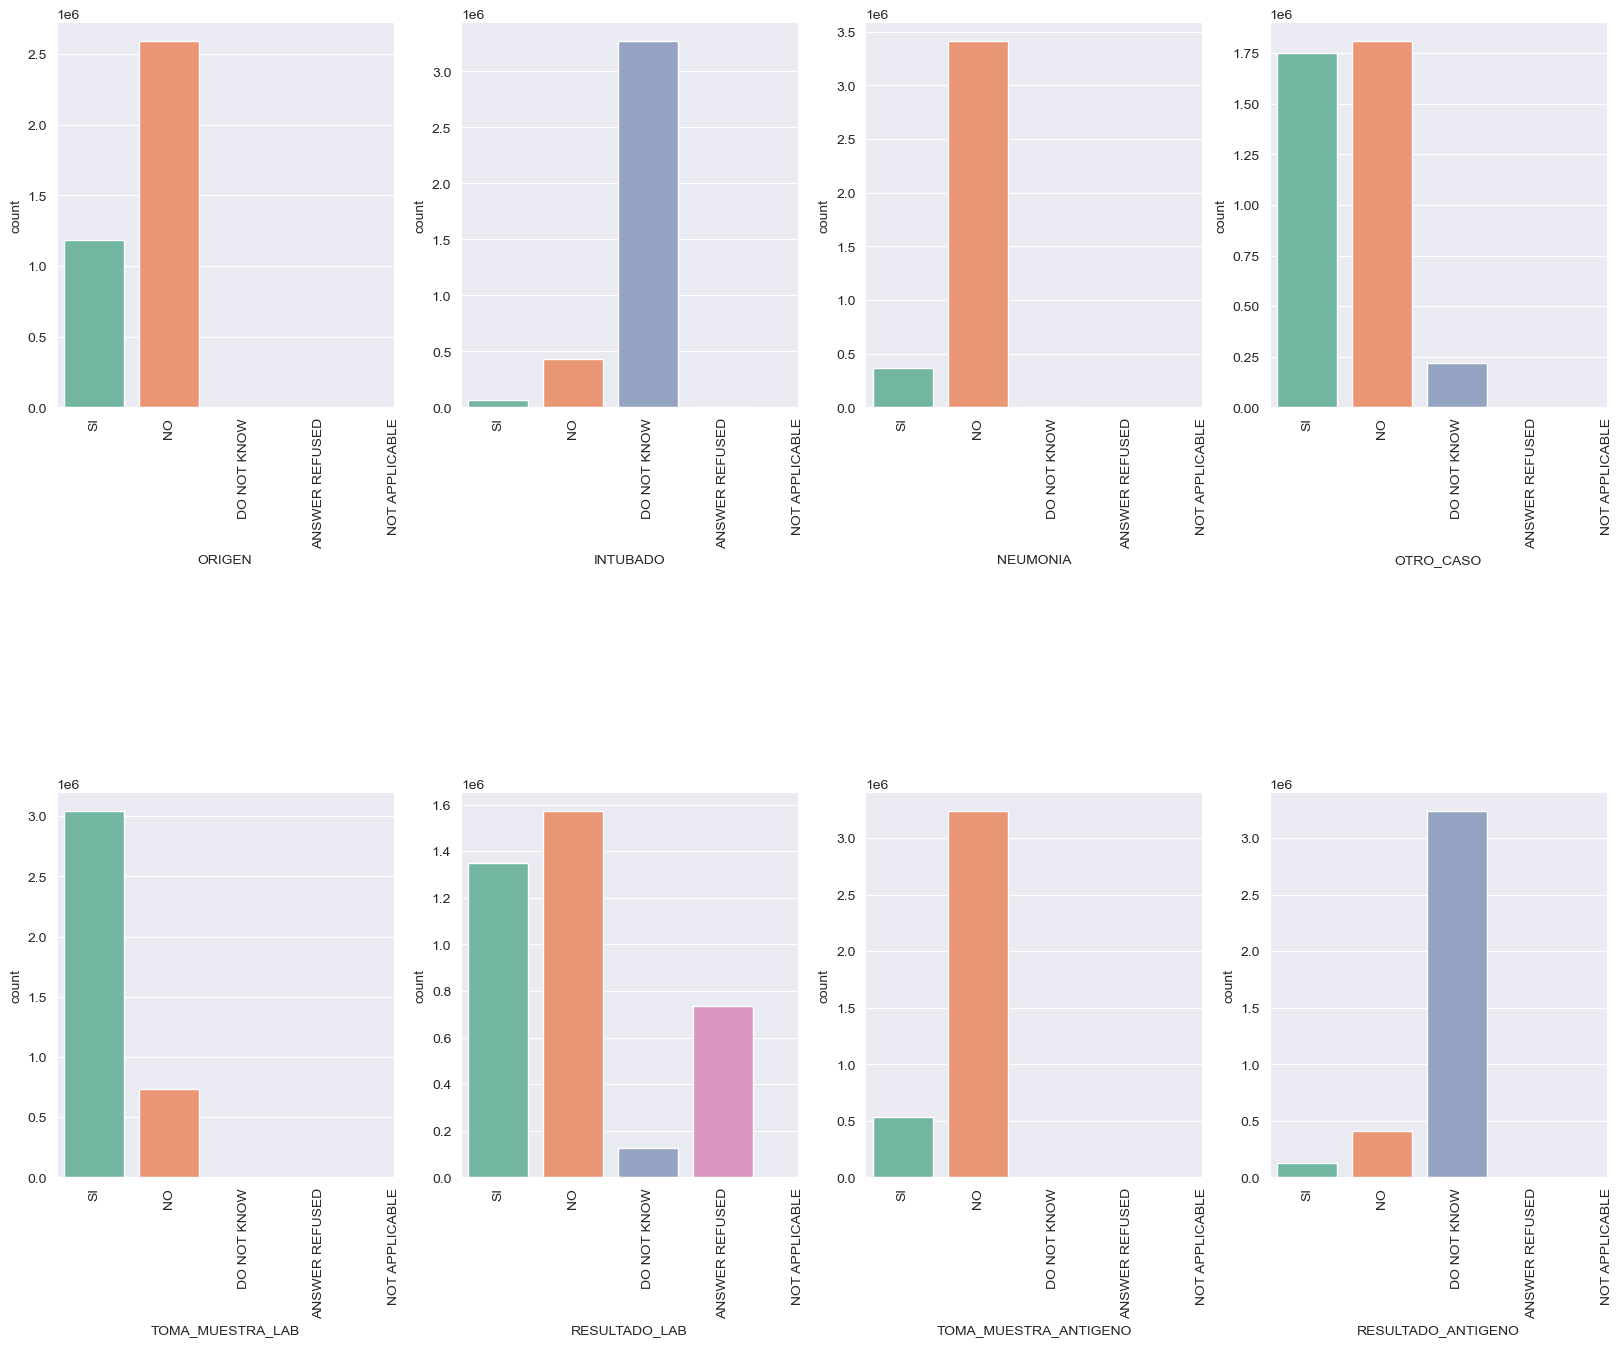

In [19]:
fig, ax = plt.subplots(2, 4, figsize=(20, 15))
fig.subplots_adjust(hspace=1)
for variable, subplot in zip(medical_info[1:9], ax.flatten()):
    chart = sns.countplot(x=df[variable], ax=subplot)
    chart.set_xticks(range(len(name_dict)), list(name_dict.keys()))
    chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

<AxesSubplot:xlabel='CLASIFICACION_FINAL', ylabel='count'>

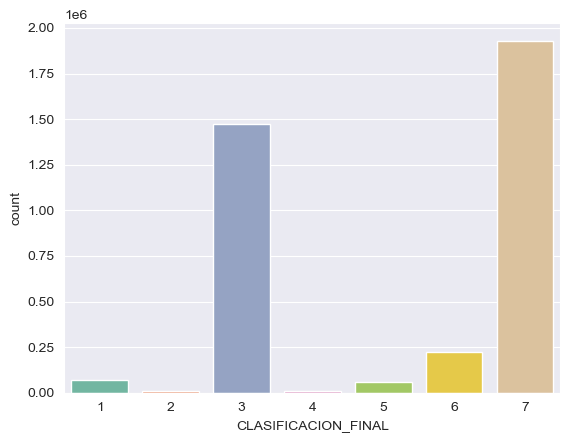

In [20]:
sns.countplot(x=df['CLASIFICACION_FINAL'])

In [21]:
# death is set to 9999-99-99 if patient is not dead
df[medical_info[-1]].value_counts()

#convert into nan to plot it
df.replace('9999-99-99', np.nan, inplace=True)

In [22]:
# convert to date
for f in medical_info[13:16]:
    df[f] =  pd.to_datetime(df[f])

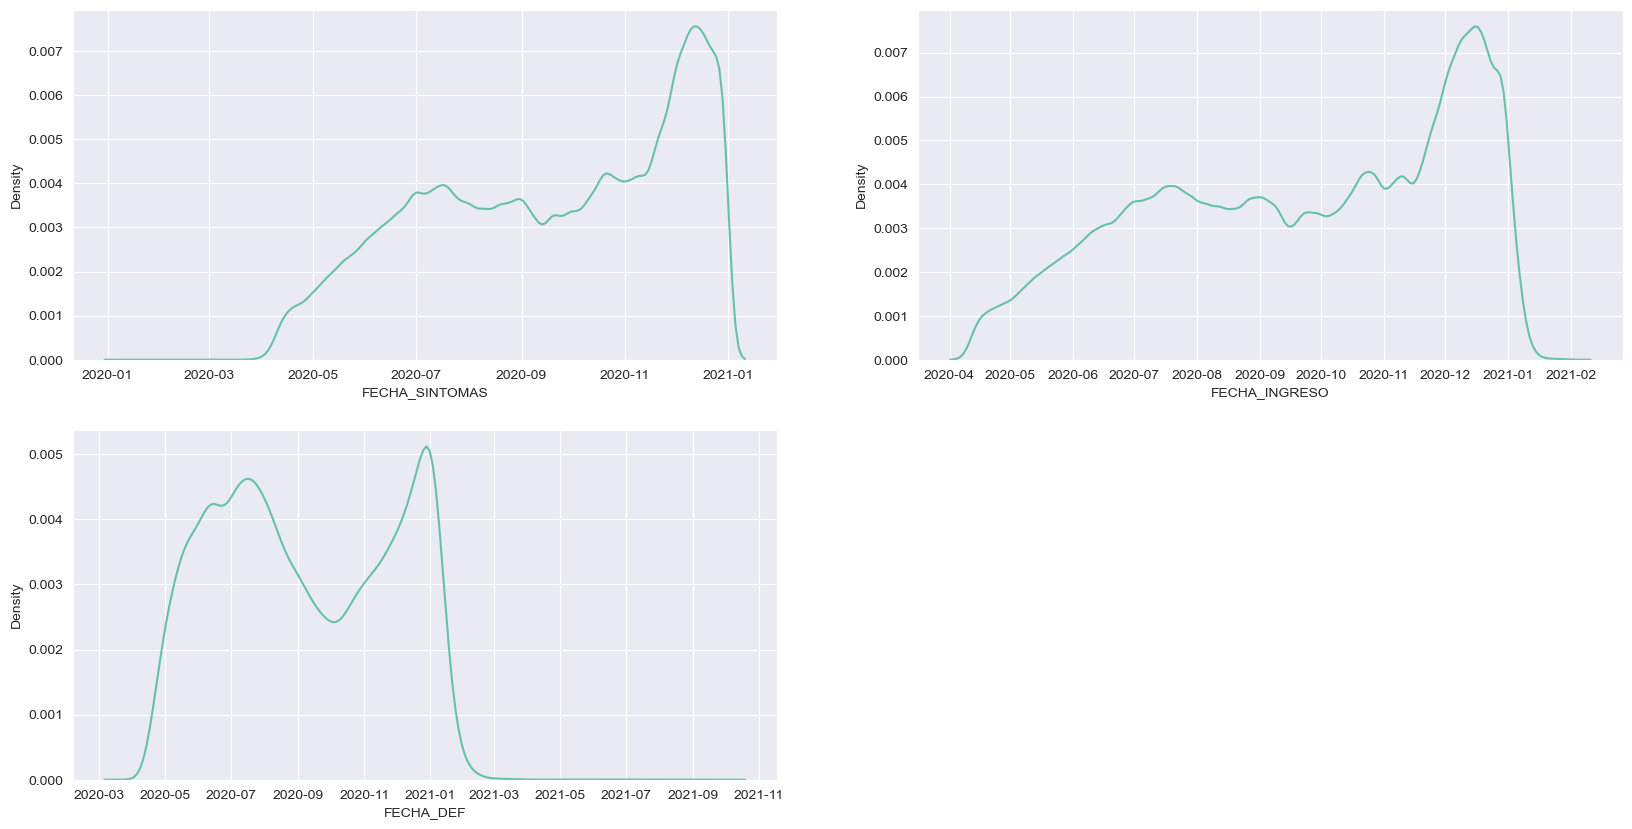

In [23]:
fig, ax = plt.subplots(2,2, figsize=(20, 10))
for variable, subplot in zip(medical_info[13:16], ax.flatten()):
    chart = sns.kdeplot(x=df[variable], ax=subplot)
fig.delaxes(ax[1,1])

- From the 'FECHA_SINTOMAS' we can clearly see a peak around the lasts month of the 2020, meaning covid19 here are a massive spread. On the same dates, we can see that many people went to the hospital ('FECHA_INGRESO'). The 'Start of symptoms' and 'Arrival to the hospital' curve are similar: there is a correlation between the two. 

- The peak for the deaths, on the other hand, are arount the lasts month of 2020 as well but also on the summer of 2020.

### **2.3 - Data Exploration:**

In [24]:
# we are going to consider 97,98,99 as NaN's values since they correspond to Don't know, Answer Refused, Not Applicable
# and this values are of no use to us
df.replace([97, 98, 99, "97", "98", "99"], np.nan, inplace=True)

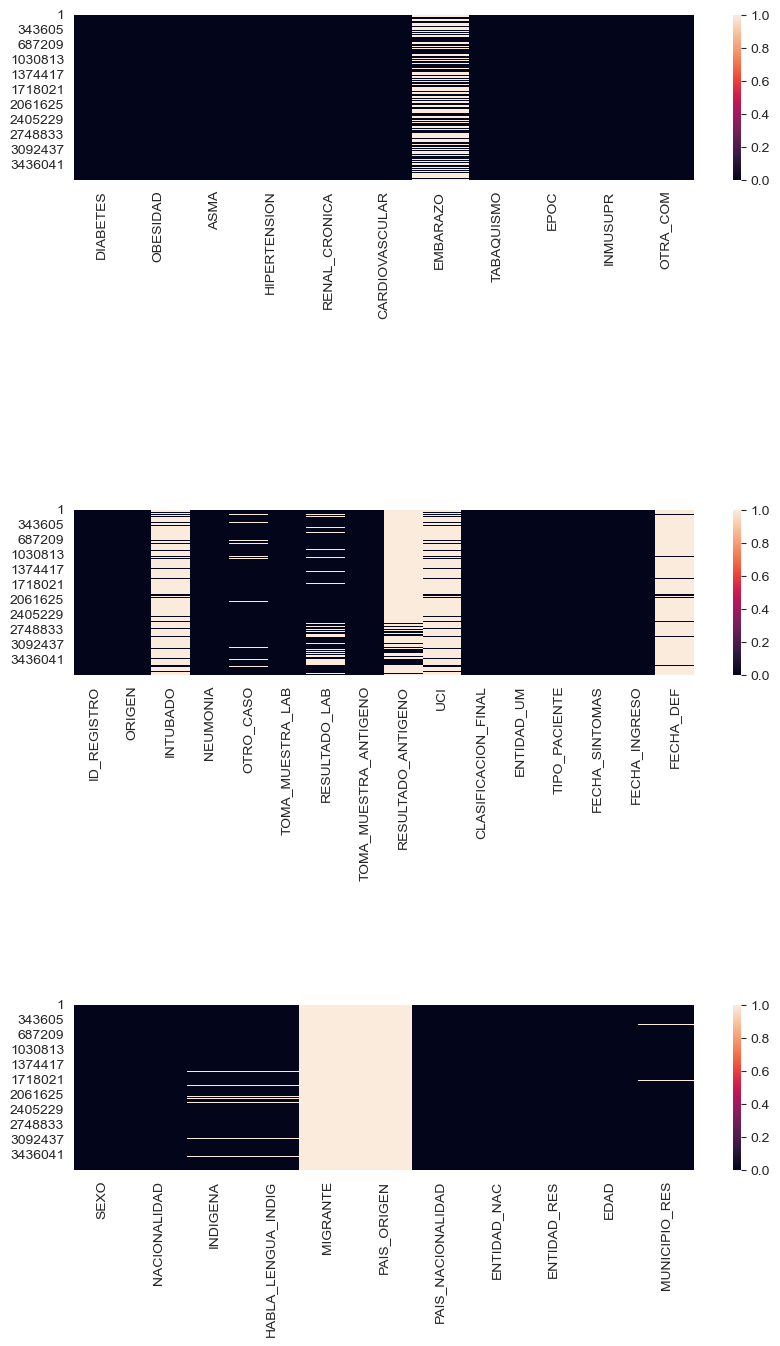

In [25]:
sections = [medical_history, medical_info, demographic_data]

fig, ax = plt.subplots(3,1, figsize=(10, 15))
fig.subplots_adjust(hspace=2)

for features, subplot in zip(sections, ax.flatten()):
    sns.heatmap(df[features].isna(), ax = subplot)

From this heatmap we can individualize with more clarity the columns with high percentage of nan values: like 'MIGRANTE' for example and 'UCI', 'RESULTADO ANTIGENO', 'INTUBADO',  'EMBARAZO'. Columns that have an high percentage of nan values are no useful to our problem. They will be removed in the future. 

Due to the nature of our problem (decide is a patient is likely to die or to survive) we won't know the value of the column 'date of death' in real life cases. So we can remove it. 

1. How many days between the start of sintoms and the ingress at the hospital?

In [26]:
df['DAYS_IN_BETWEEN'] = (df['FECHA_INGRESO'] - df['FECHA_SINTOMAS']).astype('timedelta64[D]').astype('int64')

In [27]:
df['DAYS_IN_BETWEEN'].value_counts().sort_index()

-13          1
 0      709605
 1      431457
 2      499507
 3      514451
         ...  
 153         1
 166         1
 247         1
 258         1
 265         1
Name: DAYS_IN_BETWEEN, Length: 91, dtype: int64

Text(0.5, 1.0, 'Days between start of syntoms and hospitalization')

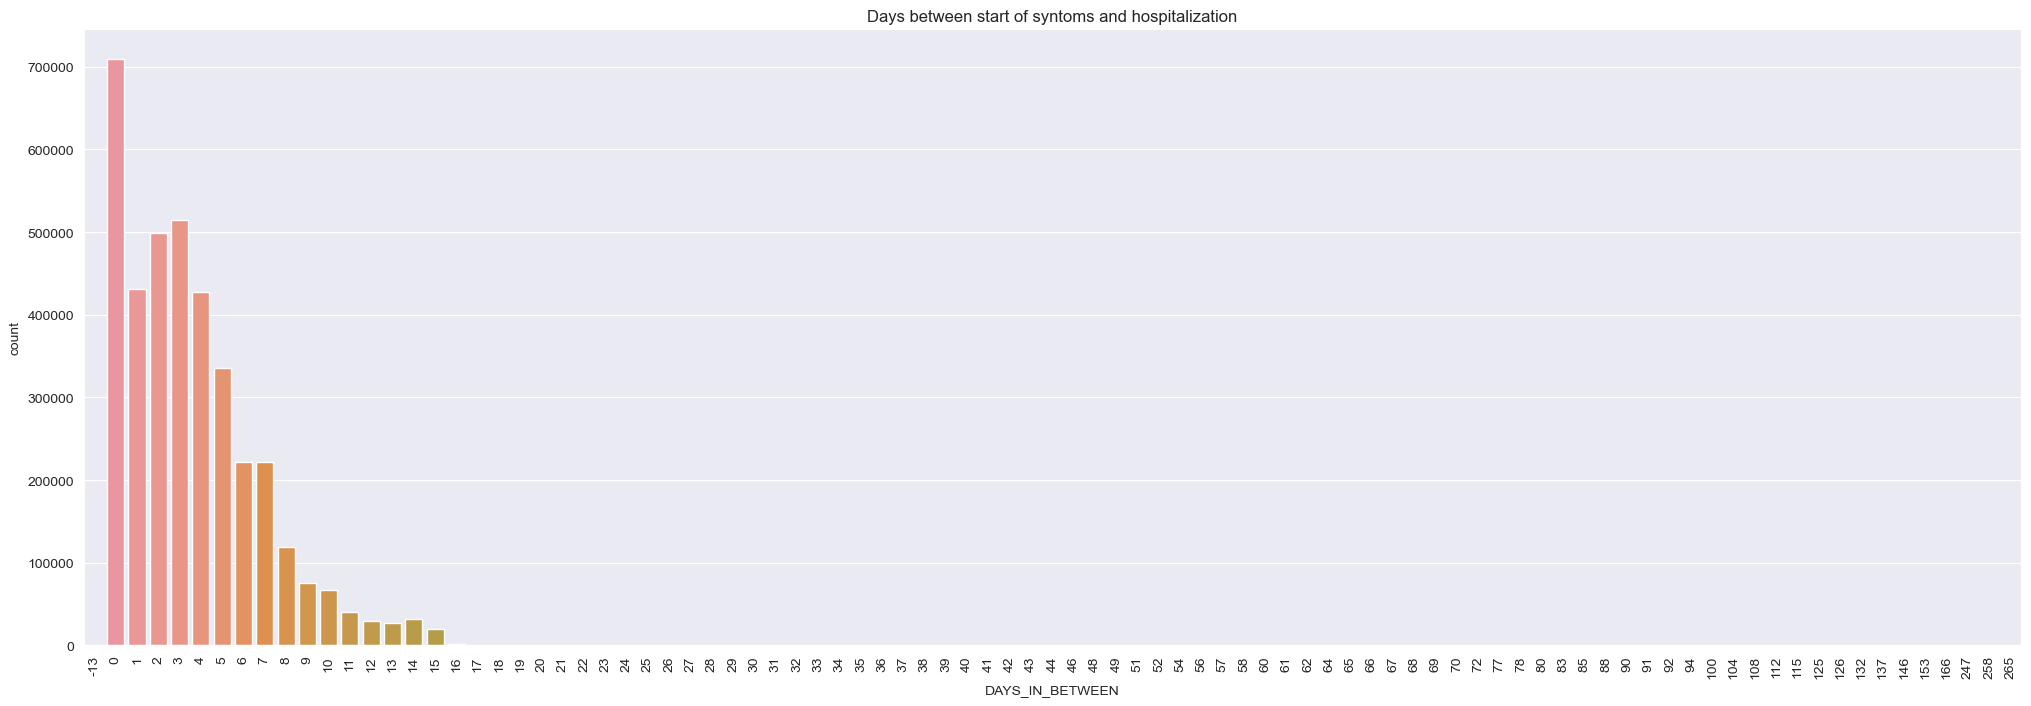

In [28]:
plt.figure(figsize=(25, 8))
cplot = sns.countplot(x=df["DAYS_IN_BETWEEN"])
cplot.set_xticklabels(cplot.get_xticklabels(), rotation=90)
cplot.set_title('Days between start of syntoms and hospitalization')

2. Is there a correlation between the days and the death?

In [29]:
df_dead = df[['DAYS_IN_BETWEEN', 'FECHA_DEF']].copy()
df_dead['DEAD'] = np.where(df_dead[['FECHA_DEF']].isna(), False, True)
df_dead[['DAYS_IN_BETWEEN', 'DEAD']].corr()

,DAYS_IN_BETWEEN,DEAD
DAYS_IN_BETWEEN,1.000000,0.096023
DEAD,0.096023,1.000000


We can say that no, there is not a visible correlation. Since the correlation between the two features is close to 0. 

3. Explore the age of people and their classification

[Text(0, 0, 'Likely to survive'), Text(1, 0, 'Likely to die')]

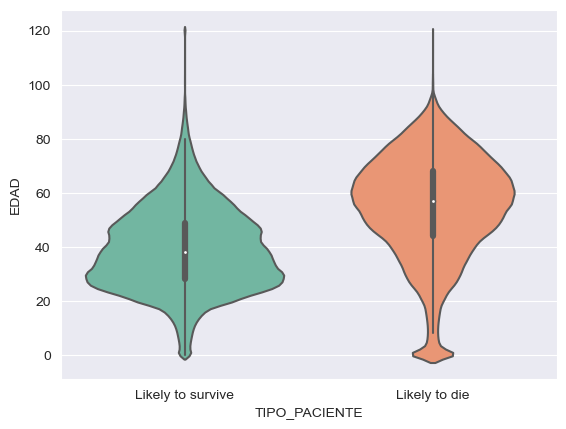

In [30]:
violin_plot = sns.violinplot(x=df["TIPO_PACIENTE"], y = df['EDAD'])
violin_plot.set_xticklabels(['Likely to survive', 'Likely to die'])

From the violion plot above, we can conclude that most of the people that were hospitalized (likely to die) had 60 years. The distrubution of people that were considered likely to die grows with the age until 60. 

Most of the people that were likely to survive has around 20-40 years instead.

4. Is the distribution of people that were likely to die/survive different between man and women?

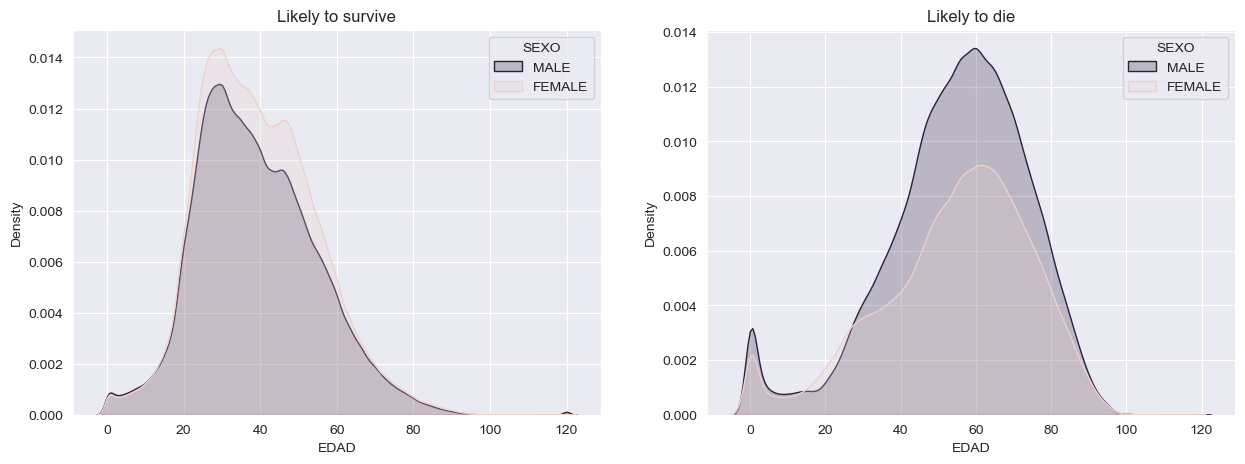

In [31]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))

c1 = sns.kdeplot(data=df[df['TIPO_PACIENTE']==1], x='EDAD', hue = 'SEXO', fill=True, ax=ax1)
c1.set_title("Likely to survive")
c2 = sns.kdeplot(data=df[df['TIPO_PACIENTE']==2], x='EDAD', hue = 'SEXO', fill=True, ax=ax2)
c2.set_title("Likely to die")

c1.legend(title='SEXO', labels=['MALE', 'FEMALE'])
c2.legend(title='SEXO', labels=['MALE', 'FEMALE'])

plt.show()

From the density plot we can see that the percentage of mens in their 60 that were likely to die is higher than womens. However the difference in sex between the ones that were likely to survive is minimal.

<AxesSubplot:>

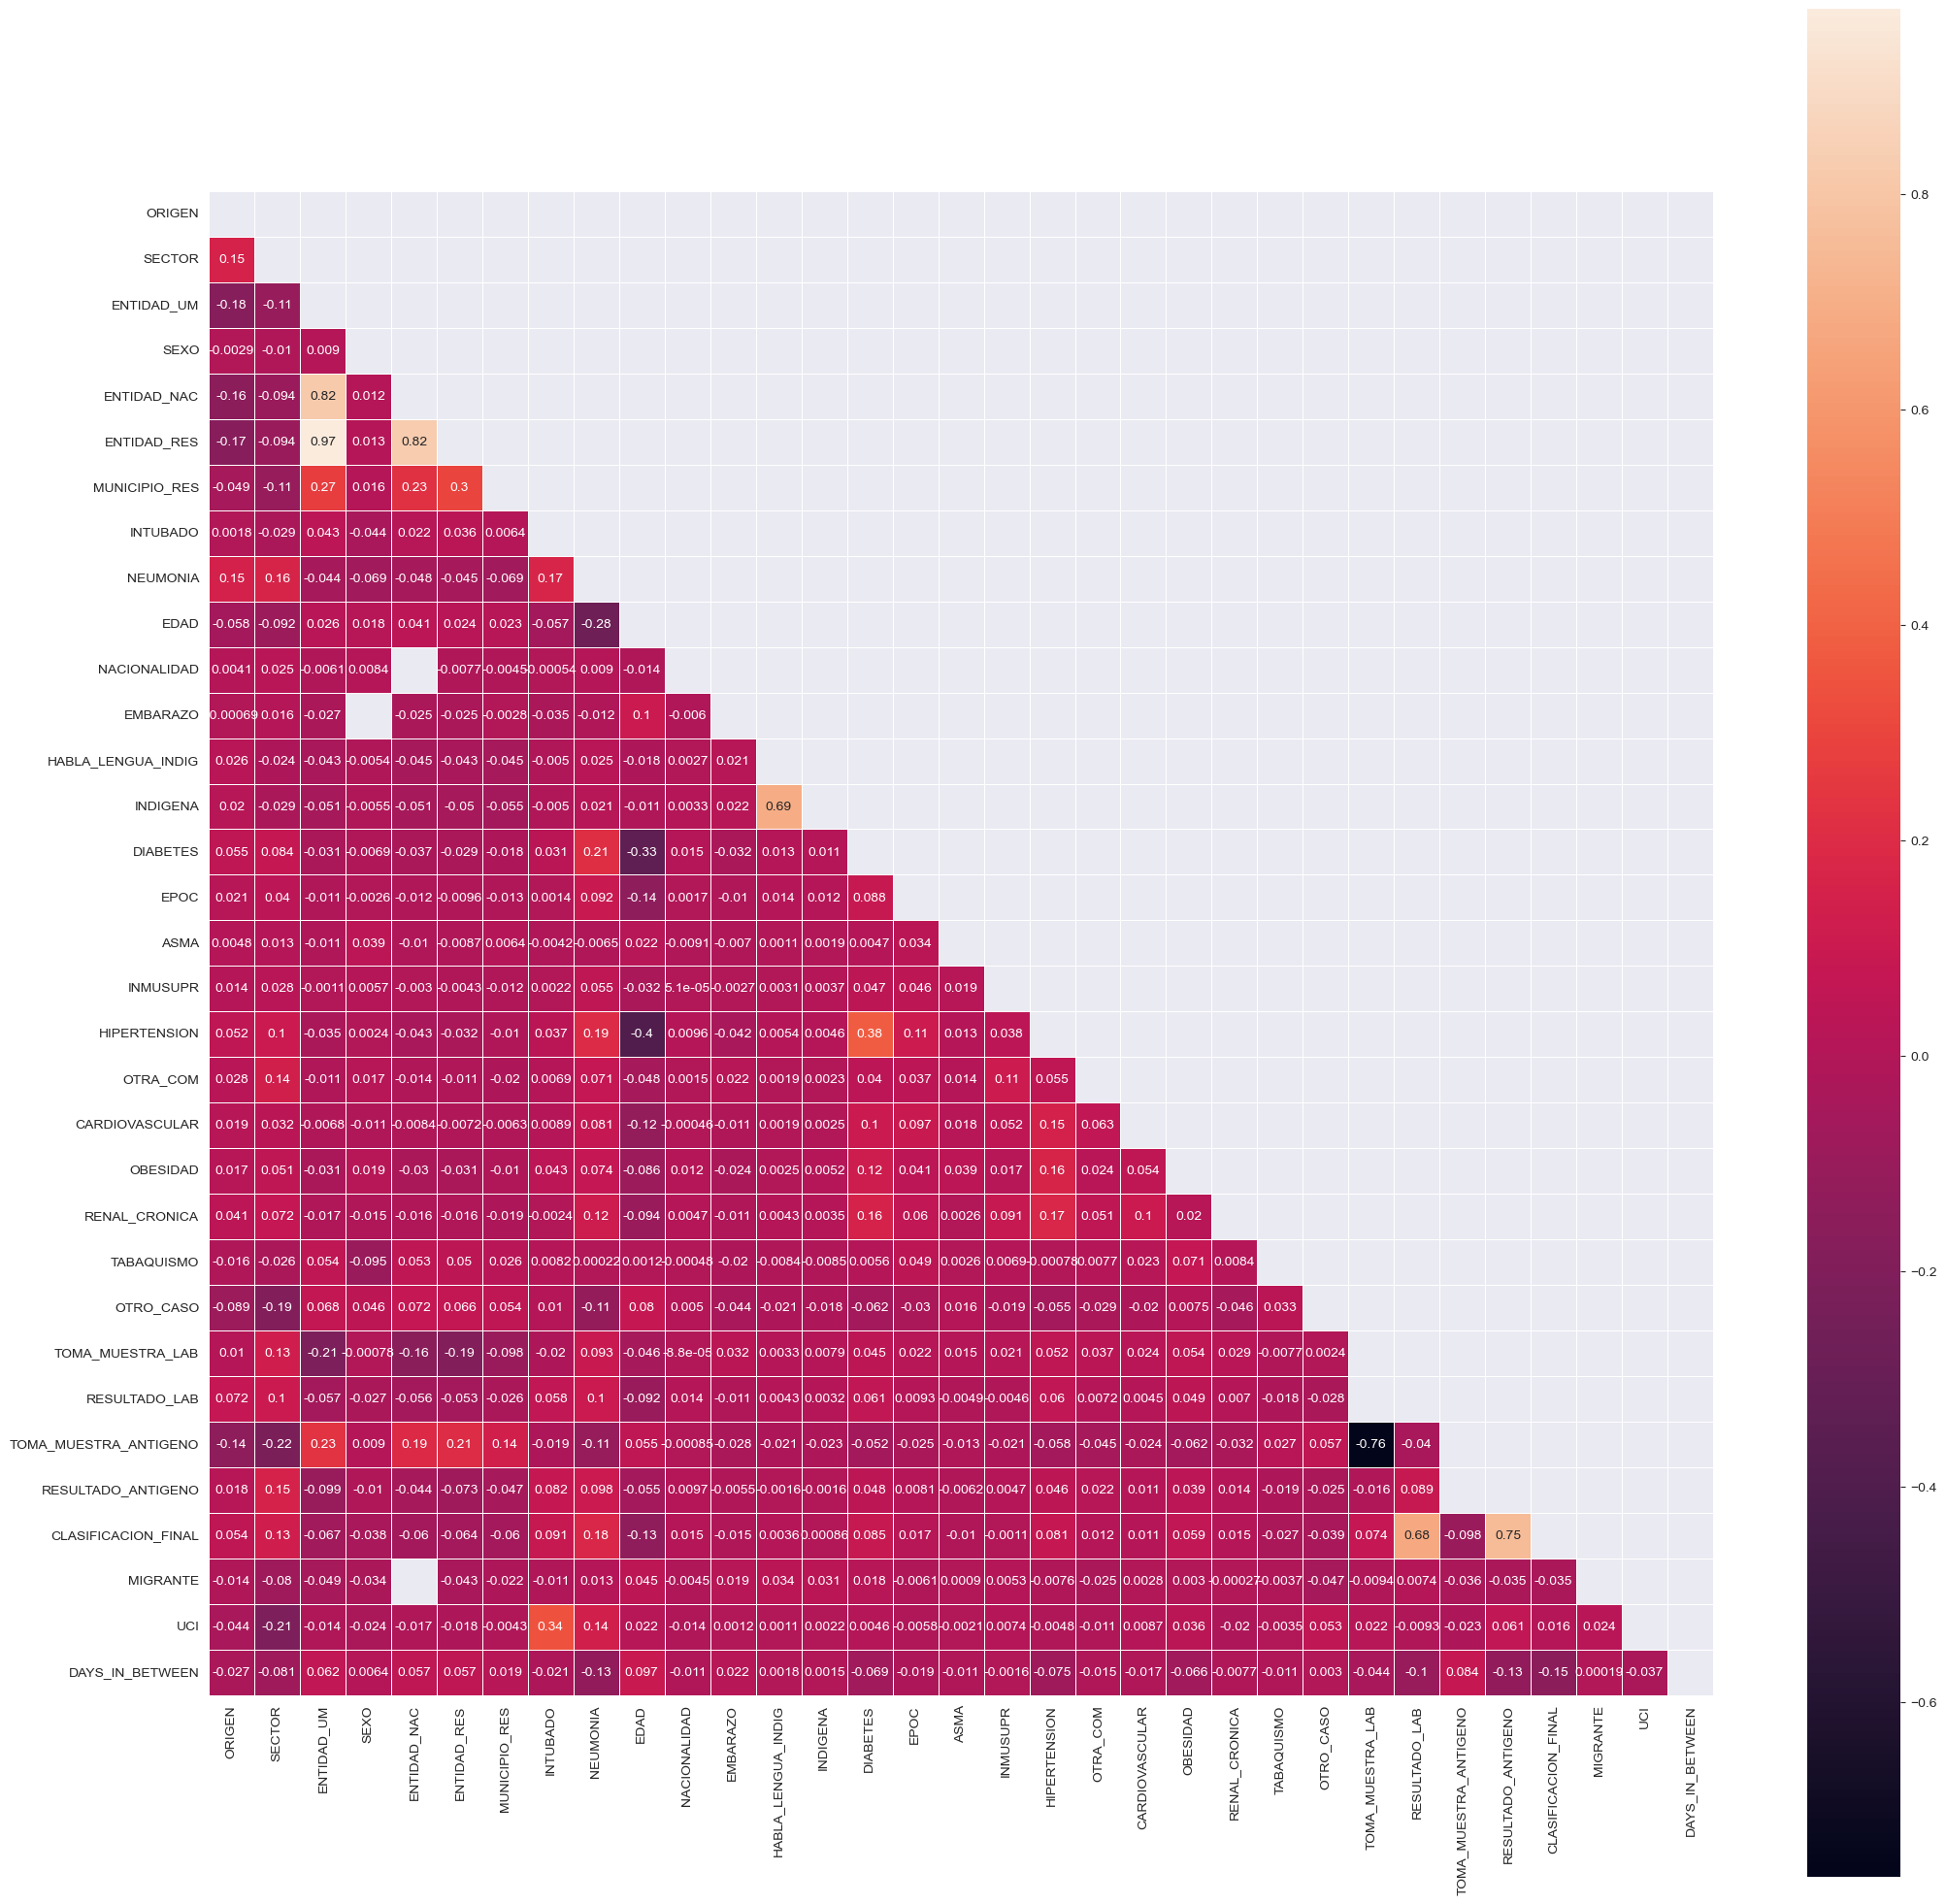

In [32]:
# correlation plot
df_corr = df.copy()
df_corr.pop('TIPO_PACIENTE')

plt.figure(figsize=(25, 25))
corr_matrix=df_corr.corr()

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr_matrix, mask=mask, square=True, linewidth=.5, annot=True)

The correlation plot show us wich features are highly correlated between themselves and which not. This can be useful because if we notice that two features are highly correlated (the more the correlation close to 1/-1, the more correlated) we can delete one and leave the other without removing information but improving training time.

For example 'ENTIAD_RES' and 'ENTIAD_UM' have an high correlation (0.97) so we can remove 'ENTIAD_RES' and keep 'ENTIAD_UM'.

In [33]:
df.drop('DAYS_IN_BETWEEN', axis=1, inplace=True)

# 3. Data Preparation

In [34]:
import gc; gc.collect()

0

### **3.0 - Remove un-necessary columns**

In [35]:
# remove the id in the register
df.drop(['ID_REGISTRO'], axis=1, inplace=True)
# remove date of insert into register
df.drop(['FECHA_ACTUALIZACION'], axis=1, inplace=True)
# date of death - if we want to predict if a patient is likely to die or survive, we won't have this feature when making real time prediction
df.drop(['FECHA_DEF'], axis=1, inplace=True)

### **3.1 - Remove NaNs**

In [36]:
df.isna().mean()*100

ORIGEN                    0.000000
SECTOR                    0.000265
ENTIDAD_UM                0.000000
SEXO                      0.000000
ENTIDAD_NAC               0.464145
ENTIDAD_RES               0.000000
MUNICIPIO_RES             0.634637
TIPO_PACIENTE             0.000000
FECHA_INGRESO             0.000000
FECHA_SINTOMAS            0.000000
INTUBADO                 86.752839
NEUMONIA                  0.000212
EDAD                      0.026008
NACIONALIDAD              0.000000
EMBARAZO                 48.621668
HABLA_LENGUA_INDIG        4.474341
INDIGENA                  4.380841
DIABETES                  0.318893
EPOC                      0.296483
ASMA                      0.291589
INMUSUPR                  0.300108
HIPERTENSION              0.298785
OTRA_COM                  0.450942
CARDIOVASCULAR            0.295160
OBESIDAD                  0.284683
RENAL_CRONICA             0.291403
TABAQUISMO                0.307119
OTRO_CASO                 5.780815
TOMA_MUESTRA_LAB    

#### **3.1.1 - Logical conclusions**

Before deciding the operations to make on the nan columns, based on the data gathered, we will manually substitute some nans based on some researches on the dataset.

In [37]:
# if the patient was sent home, the column 'INTUBADO' won't have any value because the patient wasn't intubated but sent home
df[df['INTUBADO'].isna()].head(5)
df.loc[(df['INTUBADO'].isna() & df['TIPO_PACIENTE']==1), 'INTUBADO'] = 2

In [38]:
# If you didn't change the sex legally on papers, if you're assigned as a man on the entrace of the Hospital, you can't be pregnant
df[df['EMBARAZO'].isna() & df['SEXO']==1] # sexo = gender (M/F)=(1/2)
df.loc[(df['EMBARAZO'].isna() & df['SEXO']==1), 'EMBARAZO'] = 2

In [39]:
# If you are a migrant, your nationality won't be Mexican
df[df['MIGRANTE'].isna()]
df.loc[(df['MIGRANTE'].isna() & df['NACIONALIDAD']==1), 'MIGRANTE'] = 2 # if your nationality is mexican, you're not a migrant
df.loc[(df['MIGRANTE'].isna() & df['NACIONALIDAD']==2), 'MIGRANTE'] = 1 # if your nationality is not mexican, you're a migrant

#### **3.2 - Traditional Methods**

In [40]:
# Delete columns containing either 65% or more than 65% NaN Values
perc = 65.0
min_count =  int(((100-perc)/100)*df.shape[0] + 1)
df.dropna(axis=1, thresh=min_count, inplace=True)

In [41]:
# Delete rows containing more than 10/39 NaN values
df.dropna(thresh=df.shape[1] - 10, axis=0, inplace=True)

In [42]:
# for columns with percentage of nan<10%, we are going to impute values using the simple imputer (median or most frequent)
nan_columns = df.loc[:, df.isna().any()].loc[:, df.isna().mean()<0.10].columns.tolist()

for col in nan_columns:
    if is_numeric_dtype(df[col]):
        mean_imputer = SimpleImputer(strategy='median')
        df[col] = mean_imputer.fit_transform(df[col].values.reshape(-1,1))
    else:
        mean_imputer = SimpleImputer(strategy='most_frequent')
        df[col] = mean_imputer.fit_transform(df[col].values.reshape(-1,1))

In [43]:
# get columns that still have nan values
nans_columns = df.loc[:, df.isna().any()].columns.tolist()
nans_columns

['EMBARAZO', 'RESULTADO_LAB']

In [44]:
# for more than 10% missing values we are going to use MICE
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

df_new = pd.DataFrame()

for col in nans_columns:
    df_new[col] = pd.DataFrame(mice_imputer.fit_transform(df[col].values.reshape(-1, 1)), columns=[col])

In [45]:
df.drop(nans_columns, inplace=True, axis=1)

In [46]:
df = pd.concat([df.reset_index(), df_new.reset_index()], axis=1)
df.drop('index', axis=1, inplace=True)

### **3.2 - Convert Categorical Data to Numerical**

In [47]:
obj_columns = df.select_dtypes(exclude=np.number).columns.tolist()
obj_columns

['FECHA_INGRESO', 'FECHA_SINTOMAS', 'PAIS_NACIONALIDAD']

In [48]:
df_cols = pd.DataFrame()

for col in obj_columns:
    labels = LabelEncoder().fit(df[col]).transform(df[col])
    df_cols = pd.concat([df_cols, pd.DataFrame(labels, columns=[col])], axis=1)
    
df_cols.head()

,FECHA_INGRESO,FECHA_SINTOMAS,PAIS_NACIONALIDAD
0,238,272,84
1,10,46,84
2,107,139,84
3,128,167,84
4,260,300,84


In [49]:
df.drop(obj_columns, axis=1, inplace=True)

In [50]:
df = pd.concat([df, df_cols], axis=1)

### **3.4 - Remove outliers**

In [51]:
df.describe()

,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,INTUBADO,NEUMONIA,...,OTRO_CASO,TOMA_MUESTRA_LAB,TOMA_MUESTRA_ANTIGENO,CLASIFICACION_FINAL,MIGRANTE,EMBARAZO,RESULTADO_LAB,FECHA_INGRESO,FECHA_SINTOMAS,PAIS_NACIONALIDAD
count,3.772008e+06,3.772008e+06,3.772008e+06,3.772008e+06,3.772008e+06,3.772008e+06,3.772008e+06,3.772008e+06,3.772008e+06,3.772008e+06,...,3.772008e+06,3.772008e+06,3.772008e+06,3.772008e+06,3.772008e+06,3.772008e+06,3.772008e+06,3.772008e+06,3.772008e+06,3.772008e+06
mean,1.685617e+00,9.512712e+00,1.428948e+01,1.482272e+00,1.494962e+01,1.460240e+01,3.229863e+01,1.133963e+00,1.982952e+00,1.903722e+00,...,1.536635e+00,1.194244e+00,1.857211e+00,5.215005e+00,1.998960e+00,1.985237e+00,1.639147e+00,1.622738e+02,1.986686e+02,8.386621e+01
std,4.642697e-01,3.568479e+00,7.889916e+00,4.996857e-01,7.834126e+00,7.822108e+00,4.404731e+01,3.406127e-01,1.294491e-01,2.949727e-01,...,4.986561e-01,3.956176e-01,3.498573e-01,1.985767e+00,3.223682e-02,8.677885e-02,6.189619e-01,7.413033e+01,7.432573e+01,3.371908e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,4.000000e+00,9.000000e+00,1.000000e+00,9.000000e+00,9.000000e+00,7.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,...,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,1.985237e+00,1.000000e+00,1.000000e+02,1.360000e+02,8.400000e+01
50%,2.000000e+00,1.200000e+01,1.100000e+01,1.000000e+00,1.300000e+01,1.300000e+01,1.700000e+01,1.000000e+00,2.000000e+00,2.000000e+00,...,2.000000e+00,1.000000e+00,2.000000e+00,7.000000e+00,2.000000e+00,2.000000e+00,1.639147e+00,1.710000e+02,2.080000e+02,8.400000e+01
75%,2.000000e+00,1.200000e+01,2.000000e+01,2.000000e+00,2.100000e+01,2.000000e+01,3.900000e+01,1.000000e+00,2.000000e+00,2.000000e+00,...,2.000000e+00,1.000000e+00,2.000000e+00,7.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.320000e+02,2.690000e+02,8.400000e+01
max,2.000000e+00,1.300000e+01,3.200000e+01,2.000000e+00,3.200000e+01,3.200000e+01,9.990000e+02,2.000000e+00,2.000000e+00,2.000000e+00,...,2.000000e+00,2.000000e+00,2.000000e+00,7.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00,2.940000e+02,3.030000e+02,1.400000e+02


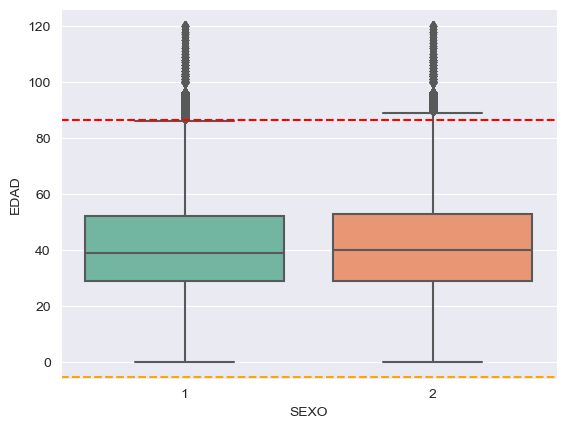

In [52]:
# outliers in edad
q3 = df['EDAD'].quantile(.75)
q1 = df['EDAD'].quantile(.25)
iqr = q3-q1
topcut = q3+1.5*iqr
lowcut = q1-1.5*iqr

ax = sns.boxplot(x='SEXO', y='EDAD', data=df)
ax.axhline(topcut,c='red',ls='--')
ax.axhline(lowcut,c='orange',ls='--')

In [53]:
columns = df.columns
columns = columns.drop('TIPO_PACIENTE')
columns

Index(['ORIGEN', 'SECTOR', 'ENTIDAD_UM', 'SEXO', 'ENTIDAD_NAC', 'ENTIDAD_RES',
       'MUNICIPIO_RES', 'INTUBADO', 'NEUMONIA', 'EDAD', 'NACIONALIDAD',
       'HABLA_LENGUA_INDIG', 'INDIGENA', 'DIABETES', 'EPOC', 'ASMA',
       'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR', 'OBESIDAD',
       'RENAL_CRONICA', 'TABAQUISMO', 'OTRO_CASO', 'TOMA_MUESTRA_LAB',
       'TOMA_MUESTRA_ANTIGENO', 'CLASIFICACION_FINAL', 'MIGRANTE', 'EMBARAZO',
       'RESULTADO_LAB', 'FECHA_INGRESO', 'FECHA_SINTOMAS',
       'PAIS_NACIONALIDAD'],
      dtype='object')

In [54]:
# using IQR range
for col in columns:
    q3 = df[col].quantile(.75)
    q1 = df[col].quantile(.25)
    iqr = q3-q1
    topcut = q3+1.5*iqr
    lowcut = q1-1.5*iqr

    df.drop(df.index[df[col]>topcut], inplace=True)
    df.drop(df.index[df[col]<lowcut], inplace=True)

### **3.3 Normalization:** <br>

In [55]:
# we need normalization for the KNN imputer
scaler = StandardScaler()
y = df.pop('TIPO_PACIENTE')
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns)

In [56]:
df = pd.concat([df.reset_index(), pd.DataFrame(y).reset_index()], axis=1)
df.drop('index', axis=1, inplace=True)

### **3.5 - Remove redundant columns**

In [57]:
X = df.copy()
y = X.pop('TIPO_PACIENTE')

In [58]:
# remove columns that are higly correlated between themselves
cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.75)]
to_drop

['ENTIDAD_NAC', 'ENTIDAD_RES', 'EMBARAZO', 'RESULTADO_LAB', 'FECHA_SINTOMAS']

In [59]:
X.drop(to_drop, axis=1, inplace=True)

In [60]:
# save result 
df = pd.concat([X, y], axis=1)

In [61]:
df.to_csv(path + "/COVID2022_processed.csv", index=False)

### **3.6- Feature Selection**

The curse of dimensionality is a problem that occurs when the dimensionality rises and the volume of space expands so quickly that available data becomes sparse. The amount of data required to produce a reliable conclusion sometimes climbs exponentially with dimensionality. Therefore it's useful to reduce the dimensionality of the data (reduce the features) to avoid this problem. Also, dimensionality reduction is useful for reducing overfitting, improving accuracy and reducing training times.

#### **3.6.1 - Principal Component Analysis**

In [62]:
# build the covariance matrix that represents the correlation between two variables
df_cov_matrix = np.cov(X.T)

In [63]:
# calculate eigenvalues and eigenvectors
eig_vals, eig_vecs = np.linalg.eig(df_cov_matrix)
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

total = sum(eig_vals)
var_exp = [(i / total)*100 for i in sorted(eig_vals, reverse=True)]
print(f"Variance captured by each component is: {var_exp}")

cum_var_exp = np.cumsum(var_exp)
print("Cumulative variance captured as we travel with each component",cum_var_exp)

Variance captured by each component is: [16.74367365956806, 13.371781454529291, 11.685880242724378, 11.233497254054935, 10.433229600857013, 10.34335604286715, 10.025184752535543, 8.524635396244488, 7.638761596619144, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Cumulative variance captured as we travel with each component [ 16.74367366  30.11545511  41.80133536  53.03483261  63.46806221
  73.81141825  83.83660301  92.3612384  100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.         100.         100.
 100.         100.         100.        ]


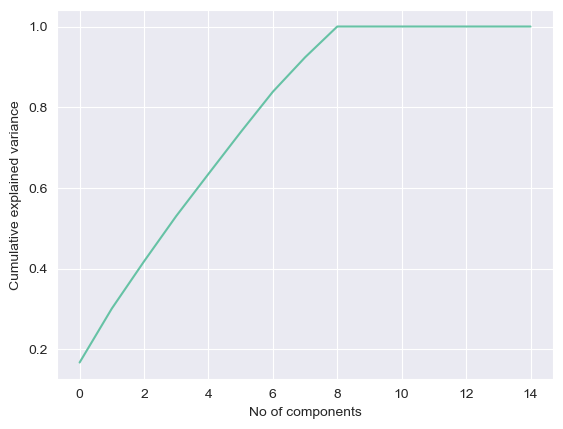

In [64]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_)[:15])
plt.xlabel("No of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [65]:
n_components = 5
pca = PCA(n_components = n_components) # the first 5 components capture enough variance
pcs = pca.fit_transform(X)
X_new = pd.DataFrame(data=pcs, columns=[f"PC{i}" for i in range(0,n_components)])

In [66]:
df_pca = pd.concat([X_new.reset_index(), y.reset_index()], axis=1)
df_pca.drop('index', axis=1, inplace=True)
df_pca.head()

,PC0,PC1,PC2,PC3,PC4,TIPO_PACIENTE
0,0.100387,-0.384216,1.248132,-1.250339,0.520514,1
1,-0.382581,0.175067,0.441366,-1.456849,-0.062254,1
2,-0.718920,-0.350160,0.418086,-1.290726,-0.200972,1
3,0.225529,1.330171,0.246676,-1.818103,-0.312713,1
4,2.012480,0.614245,0.643765,1.437392,-1.794783,1


In [67]:
print(f"Original Dataset features len: {df.shape[1]}")
print(f"PCA Dataset features len: {df_pca.shape[1]}")

Original Dataset features len: 29
PCA Dataset features len: 6


In [68]:
df_pca.to_csv(path + '/COVID2022_processed_PCA.csv', index=False)

#### **3.6.2 - Feature Selection**

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, shuffle=True, random_state=42)

In [70]:
model = GradientBoostingRegressor(learning_rate=0.05, max_depth=5, n_estimators=500, min_samples_split=5, n_iter_no_change=10)
model.fit(X_train, y_train)

rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
rmse

0.16992543796885862

In [71]:
# permutation importance 

perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

sorted_idx = perm_importance.importances_mean.argsort()

Text(0.5, 1.0, 'Permutation Importance')

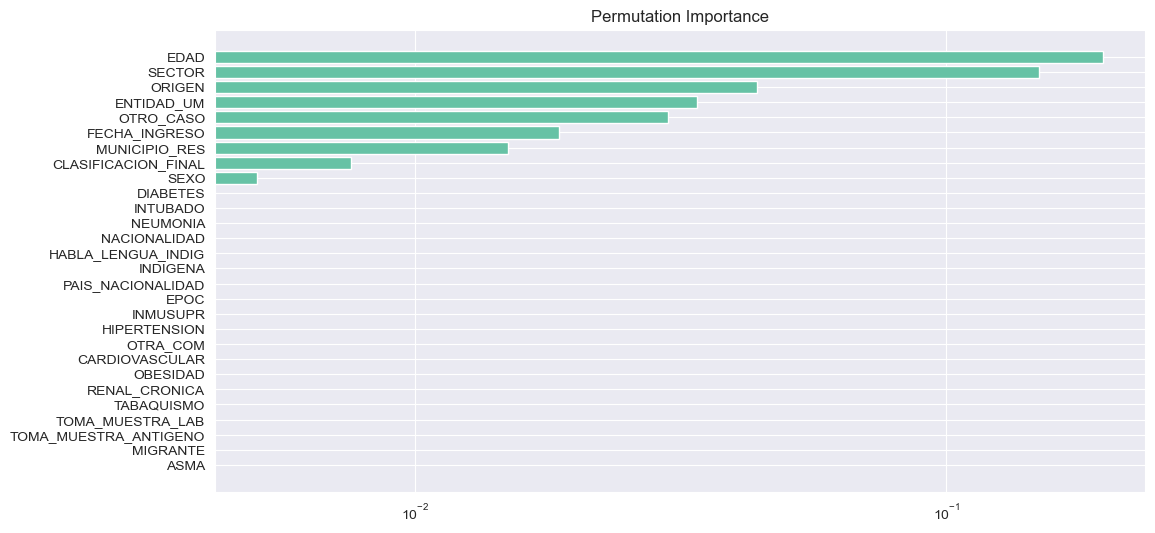

In [72]:
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center', log=True)
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')

In [73]:
important = np.array(X_test.columns)[sorted_idx][-9:].tolist()
important

['SEXO',
 'CLASIFICACION_FINAL',
 'MUNICIPIO_RES',
 'FECHA_INGRESO',
 'OTRO_CASO',
 'ENTIDAD_UM',
 'ORIGEN',
 'SECTOR',
 'EDAD']

from the plot we can see that the only important features are 'SEXO', 'CLASIFICACION_FINAL', 'MUNICIPIO_RES', 'FECHA_INGRESO', 'OTRO_CASO', 'ENTIDAD_UM', 'ORIGEN', 'SECTOR', 'EDAD'

In [74]:
df_fs = df[important]

In [75]:
df_fs.to_csv(path + '/COVID2022_processed_feature_selection.csv', index=False)

# 4. Modelling

-------
*functions*

In [76]:
def train_test(X_res, y_res, model):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X_res, y_res, scoring="roc_auc", cv=cv, n_jobs=-1) 

    print('Mean ROC AUC: %.3f \n' % mean(scores))
    
    y_pred = cross_val_predict(model, X_res, y_res, cv=5)
    
    print("Number of mislabeled points out of a total %d points : %d \n" 
      % (X_res.shape[0], (y_res != y_pred).sum()))
        
    print('Accuracy Score: %.3f \n' % accuracy_score(y_res, y_pred))
    print('Precision Score: %.3f \n' % precision_score(y_res, y_pred))
    print('Recall Score: %.3f \n' % recall_score(y_res, y_pred))
    print('F1-Score Score: %.3f \n' % f1_score(y_res, y_pred))

    cm = confusion_matrix(y_res, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
    plt.show()

In [77]:
def resample(X, y, majority, minitory):
    rus = RandomUnderSampler(sampling_strategy={1: majority , 2: minority})
    X_res, y_res = rus.fit_resample(X, y)
    print('Resampled dataset shape %s' % Counter(y_res))
    
    sm = BorderlineSMOTE(sampling_strategy='not majority')
    X_res, y_res = sm.fit_resample(X_res, y_res)
    print('Resampled dataset shape %s' % Counter(y_res))
    
    return X_res, y_res

In [78]:
def plot_decision_boundaries(model, X, y):
    
    model.fit(X.iloc[:, 1:3], y)
    
    disp = DecisionBoundaryDisplay.from_estimator(model, X.iloc[:, 1:3], response_method="predict",
    xlabel=X.columns[1], ylabel=X.columns[2], alpha=0.5)
    
    disp.ax_.scatter(X.iloc[:, 1], X.iloc[:, 2], c=y, edgecolor="k")
    
    plt.show()

------

In [79]:
df = pd.read_csv(path + '/COVID2022_processed.csv')
df_fs = pd.read_csv(path + '/COVID2022_processed_feature_selection.csv')
df_pca = pd.read_csv(path + '/COVID2022_processed_PCA.csv')

In [80]:
df_s = df.sample(frac=0.3)

majority = int(0.2*len(df_s))
minority = len(df_s[df_s['TIPO_PACIENTE'] == 2])

X = df_s.copy()
y = X.pop('TIPO_PACIENTE')

In [81]:
y.value_counts()

1    415728
2     16457
Name: TIPO_PACIENTE, dtype: int64

In [82]:
X_res, y_res = resample(X, y, majority, minority)

Resampled dataset shape Counter({1: 86437, 2: 16457})
Resampled dataset shape Counter({1: 86437, 2: 86437})


#### **4.1 Nearest neighbor**

#### **4.2 Bayesian Classifier**

Naive Bayes is a generative model that assumes that each class follow a Gaussian distribution.

In [83]:
naive_bayes = GaussianNB()

USING ORIGINAL FEATURES: 

Mean ROC AUC: 0.770 

Number of mislabeled points out of a total 172874 points : 51300 

Accuracy Score: 0.703 

Precision Score: 0.710 

Recall Score: 0.686 

F1-Score Score: 0.698 



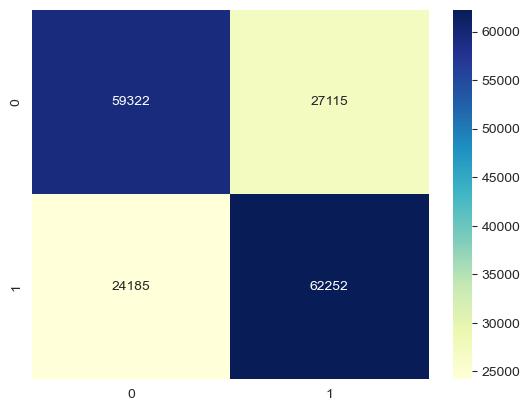

In [84]:
print("USING ORIGINAL FEATURES: \n")
train_test(X_res, y_res, naive_bayes)

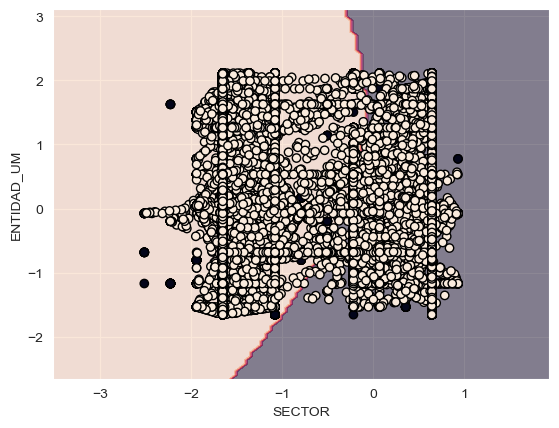

In [85]:
plot_decision_boundaries(naive_bayes, X_res, y_res)

#### **4.3 Decision Trees**

#### **4.4 Tree ensembles**

#### **4.5 Support Vector Machines**

In [86]:
svc = SVC(max_iter=10000, random_state=42)

USING ORIGINAL FEATURES: 



/Users/deborah/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/deborah/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/deborah/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/deborah/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/deborah/.local/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarni

Mean ROC AUC: 0.651 



Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


Number of mislabeled points out of a total 172874 points : 69443 

Accuracy Score: 0.598 

Precision Score: 0.609 

Recall Score: 0.549 

F1-Score Score: 0.577 



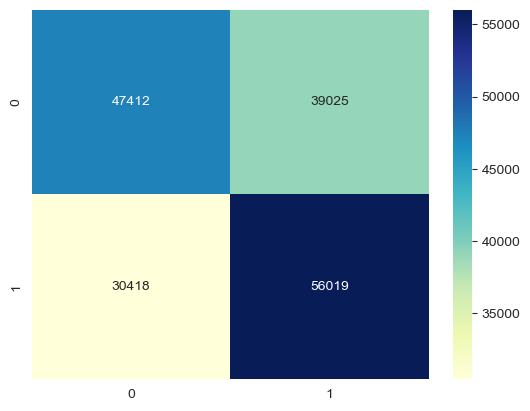

In [87]:
print("USING ORIGINAL FEATURES: \n")
train_test(X_res, y_res, svc)

Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.


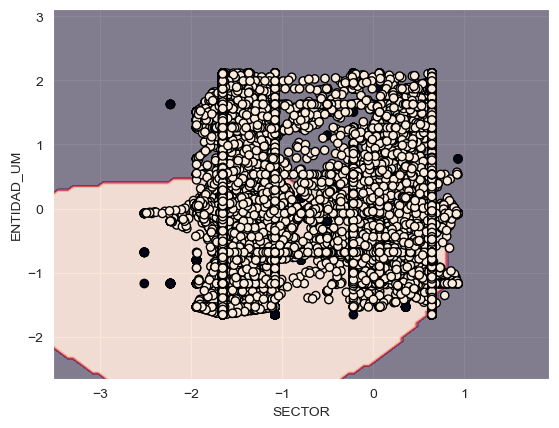

In [88]:
plot_decision_boundaries(svc, X_res, y_res)

#### **4.5 Neural Network Classifier**

In [89]:
clf = MLPClassifier(random_state=42, hidden_layer_sizes=(50,),
                    max_iter=1000,verbose=0,
                    tol=0.001, activation='logistic')

USING ORIGINAL FEATURES: 

Mean ROC AUC: 0.855 

Number of mislabeled points out of a total 172874 points : 37903 

Accuracy Score: 0.781 

Precision Score: 0.794 

Recall Score: 0.758 

F1-Score Score: 0.776 



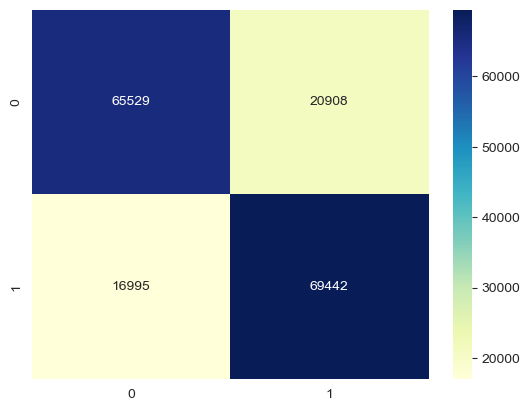

In [90]:
print("USING ORIGINAL FEATURES: \n")
train_test(X_res, y_res, clf)

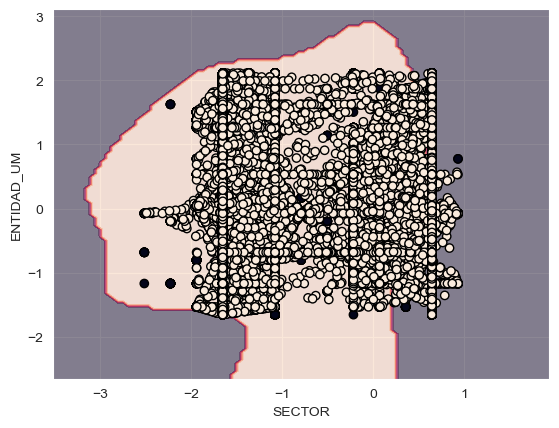

In [91]:
plot_decision_boundaries(clf, X_res, y_res)

#### **4.6 Comparison**